<a href="https://colab.research.google.com/github/roshinisanikop/Mitigating_Bias_in_Facial_Recognition_using_Seldonian_Framework/blob/main/Seldonian_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade seldonian-engine

In [1]:
# Comment the following if you are running your code locally

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs682/assignments/assignment1/'
FOLDERNAME = 'ColabNotebooks/682_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

! pip3 install datasets
#! pip install --upgrade seldonian-engine

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import numpy as np

from helper.dataloader import *
# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


## Data Preparation

In [3]:
balanced_df_train, balanced_df_test = load_fair_dataset()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.89k [00:00<?, ?B/s]

(…)-00000-of-00002-d405faba4f4b9b85.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

(…)-00001-of-00002-dd3cb68164727418.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

(…)-00000-of-00001-951dbd63c8724ee1.parquet:   0%|          | 0.00/63.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/86744 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10954 [00:00<?, ? examples/s]

In [4]:
balanced_df_train

,image,age,gender,race
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,0,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,0,3
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,0,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,0,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,7,0,3
...,...,...,...,...
26729,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,5
26730,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,1,5
26731,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,0,5
26732,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,4,0,5


In [5]:
balanced_df_test

,image,age,gender,race
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,1,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,1,3
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,0,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,1,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,0,3
...,...,...,...,...
3241,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,6,1,5
3242,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,1,5
3243,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,0,5
3244,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,5,1,5


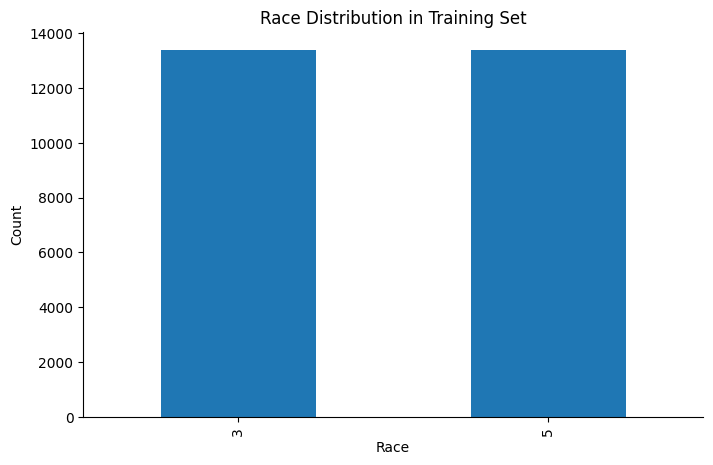

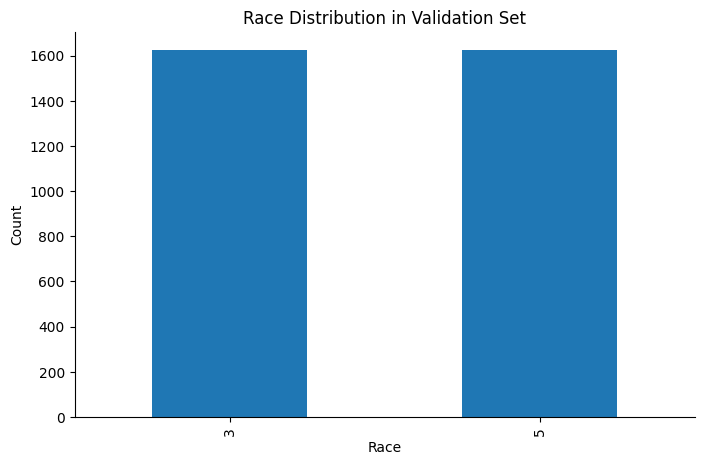

In [6]:
# Plot for training set
plt.figure(figsize=(8, 5))
balanced_df_train['race'].value_counts().plot(kind='bar', title='Race Distribution in Training Set')
plt.xlabel('Race')
plt.ylabel('Count')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Plot for validation set
plt.figure(figsize=(8, 5))
balanced_df_test['race'].value_counts().plot(kind='bar', title='Race Distribution in Validation Set')
plt.xlabel('Race')
plt.ylabel('Count')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

## Features, Labels and Sensitive attributes

In [7]:
import numpy as np
from PIL import Image
import io
from sklearn.preprocessing import OneHotEncoder
from seldonian.utils.io_utils import save_pickle

def process_rgb_image(image_dict):
    try:
        # Load image from bytes
        image_bytes = image_dict['bytes']
        image = Image.open(io.BytesIO(image_bytes))

        # Resize to (48, 48)
        image = image.resize((48, 48))

        # Convert to NumPy array
        image_array = np.array(image, dtype=np.float32)

        # Normalize to [0, 1]
        image_array /= 255.0

        return image_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Process the images
print("Processing RGB images...")
balanced_df_train['pixels'] = balanced_df_train['image'].apply(process_rgb_image)

# # Drop rows where processing failed
# balanced_df_train = balanced_df_train.dropna(subset=['pixels'])

# Convert processed images to a NumPy array
print("Converting images to NumPy array...")
X = np.array(balanced_df_train['pixels'].tolist())  # Shape: (num_samples, 48, 48, 3)

# Reshape to (num_samples, 3, 48, 48)
# images = X.transpose(0, 3, 1, 2)
images =  X.reshape(X.shape[0], 3, 48, 48)

Processing RGB images...
Converting images to NumPy array...


In [8]:
print("Encoding race and gender...")

# Encode race and gender as one-hot vectors
onehot_encoder = OneHotEncoder()
race_data = balanced_df_train[['race']].values
race_data_encoded = onehot_encoder.fit_transform(race_data).toarray().astype(int)

# # Extract labels (age)
labels = balanced_df_train['age'].values


Encoding race and gender...


In [9]:
race_data_encoded

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [10]:
# Save to pickle files
savename_features = './features.pkl'
savename_labels = './labels.pkl'
savename_sensitive_attrs = './sensitive_attrs.pkl'

print("Saving features and labels...")
save_pickle(savename_features, images)
save_pickle(savename_labels, labels)
save_pickle(savename_sensitive_attrs, race_data_encoded)

print("Processing complete.")

Saving features and labels...
Processing complete.


## Running the Seldonian experiment

In [11]:
from helper.facial_recog_model import PytorchFacialRecog

In [12]:
# Define parameters
device = 'cpu'  # or 'cuda' if using a GPU
num_classes = 9  # Example: 9 age categories

# Instantiate the model
model = PytorchFacialRecog(device=device)

# Create the CNN model
cnn_model = model.create_model()

# Print model architecture
print(cnn_model)


FacialRecogCNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (cnn4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=9, bias=True)
  (softmax): Softmax(dim=1)
)


In [13]:
from seldonian.spec import SupervisedSpec
from seldonian.dataset import SupervisedDataSet
from seldonian.utils.io_utils import load_pickle,save_pickle
from seldonian.models import objectives
from seldonian.seldonian_algorithm import SeldonianAlgorithm
from seldonian.parse_tree.parse_tree import (
    make_parse_trees_from_constraints)
import autograd.numpy as np
from types import SimpleNamespace

In [14]:
regime='supervised_learning'
sub_regime='multiclass_classification'

features = load_pickle(savename_features)
labels = load_pickle(savename_labels)
sensitive_attrs = load_pickle(savename_sensitive_attrs)

frac_data_in_safety = 0.5
sensitive_col_names = ['Three','Five']

meta_information = SimpleNamespace(
    feature_col_names=['img'],
    label_col_names=['label'],
    sensitive_col_names=sensitive_col_names,
    sub_regime=sub_regime
)

print("Making SupervisedDataSet...")
dataset = SupervisedDataSet(
    features=features,
    labels=labels,
    sensitive_attrs=sensitive_attrs,
    num_datapoints= len(balanced_df_train),
    meta = meta_information)

constraint_strs = ['min((ACC | [Three])/(ACC | [Five]),(ACC | [Three])/(ACC | [Five])) >= 0.8']
deltas = [0.05]
print("Making parse trees for constraint(s):")
print(constraint_strs," with deltas: ", deltas)


parse_trees = make_parse_trees_from_constraints(
    constraint_strs,deltas,regime=regime,
    sub_regime=sub_regime,columns=sensitive_col_names)

initial_solution_fn = model.get_model_params
#initial_solution_fn = model.get_initial_weights
primary_objective_fn = objectives.multiclass_logistic_loss

spec = SupervisedSpec(
    dataset=dataset,
    model=model,
    parse_trees=parse_trees,
    frac_data_in_safety=frac_data_in_safety,
    primary_objective=primary_objective_fn,
    use_builtin_primary_gradient_fn=False,
    sub_regime=sub_regime,
    initial_solution_fn=initial_solution_fn,
    optimization_technique='gradient_descent',
    optimizer='adam',
    optimization_hyperparams={
        'lambda_init'   : np.array([0.5]),
        'alpha_theta'   : 0.001,
        'alpha_lamb'    : 0.001,
        'beta_velocity' : 0.9,
        'beta_rmsprop'  : 0.95,
        'use_batches'   : True,
        'batch_size'    : 237,
        'n_epochs'      : 2,
        'gradient_library': "autograd",
        'hyper_search'  : None,
        'verbose'       : True,
    },

    batch_size_safety=2000
)
save_pickle('./spec.pkl',spec,verbose=True)

Making SupervisedDataSet...
Making parse trees for constraint(s):
['min((ACC | [Three])/(ACC | [Five]),(ACC | [Three])/(ACC | [Five])) >= 0.8']  with deltas:  [0.05]
Saved ./spec.pkl



In [20]:
SA = SeldonianAlgorithm(spec)
passed_safety,solution = SA.run(debug=True,write_cs_logfile=True)

if passed_safety:
    print("Passed safety test.")
else:
    print("Failed safety test")

Attempting to use initial solution function
Initial solution: 
[ 0.18906523 -0.04276561  0.10905199 ... -0.0322192   0.03060455
 -0.00738461]
Have 2 epochs and 57 batches of size 237 for a total of 114 iterations
Epoch: 0, batch iteration 0
epoch,batch_i,overall_i,f,g,theta,lambda: 0 0 0 2.2018252123257276 [inf] [ 0.18906523 -0.04276561  0.10905199 ... -0.0322192   0.03060455
 -0.00738461] [0.5]

NaN or Inf appeared in gradient descent terms Returning NSF
Wrote /content/logs/candidate_selection_log3.p with candidate selection log info
Failed safety test


# New Section